In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller

In [74]:
df=pd.read_csv('product e.csv', parse_dates=['Month-Year'], index_col='Month-Year')

In [75]:
sales_e= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [76]:
sales_e.shape

(60, 1)

In [77]:
sales_e.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2019-01-01 to 2023-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


In [78]:
sales_e['Sales'].sum()

4925930

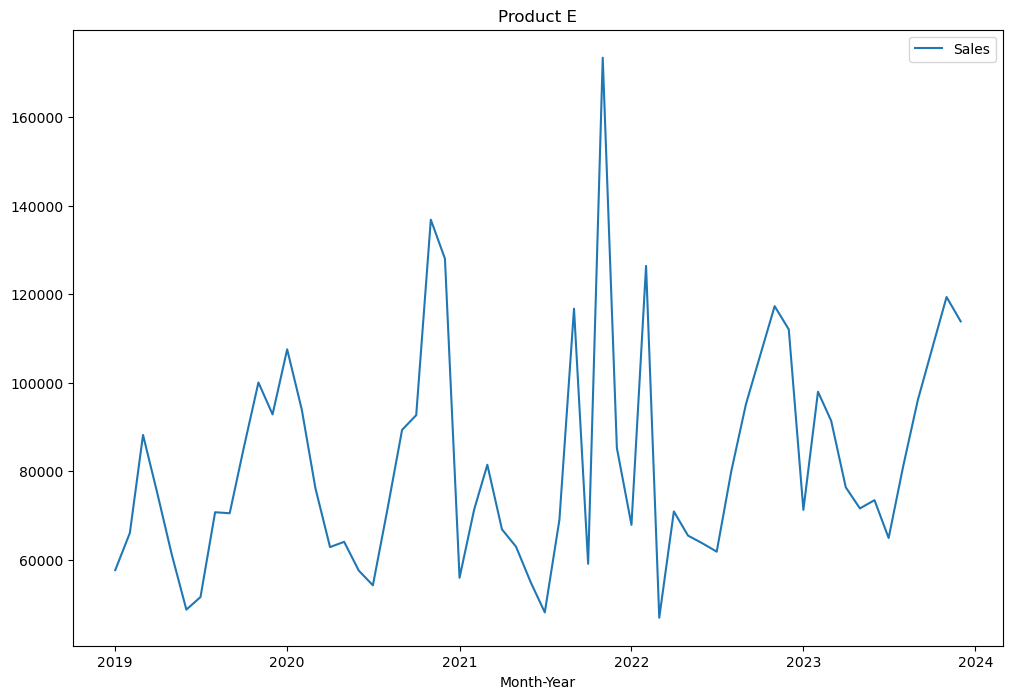

In [79]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_e)
plt.title('Product E')
plt.show()

In [80]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [81]:
adf_test(sales_e)

ADF Statistics: -1.547517694729824
p- value: 0.5098879012430942
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [82]:
sales_e_diff= sales_e.diff().dropna()

Text(0.5, 1.0, 'Product E- First Difference')

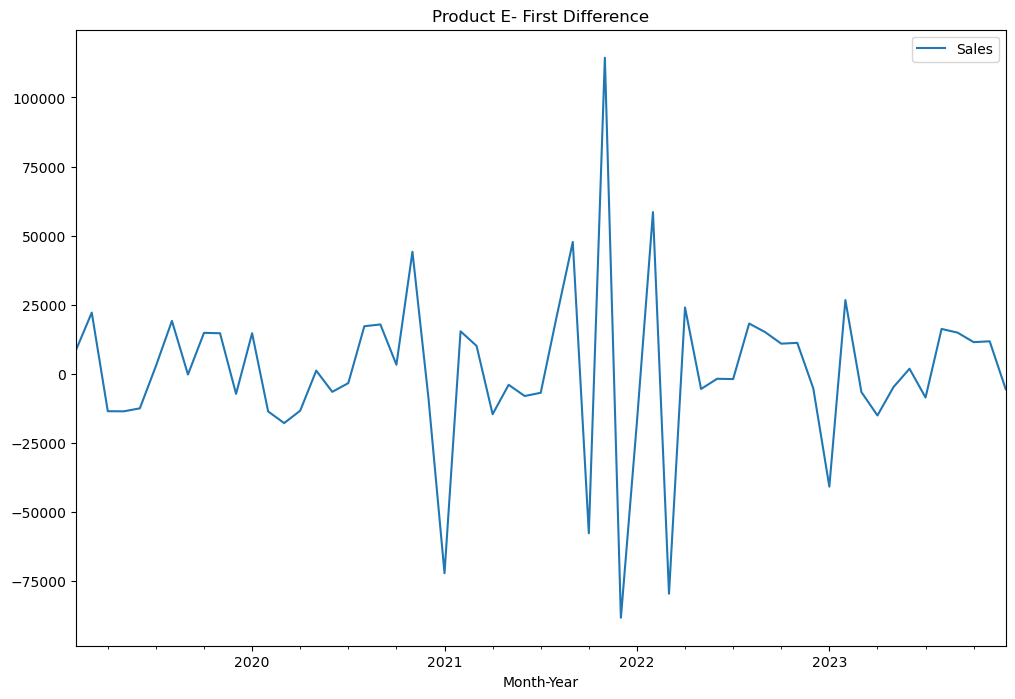

In [83]:
sales_e_diff.plot(figsize=(12, 8))
plt.title('Product E- First Difference')

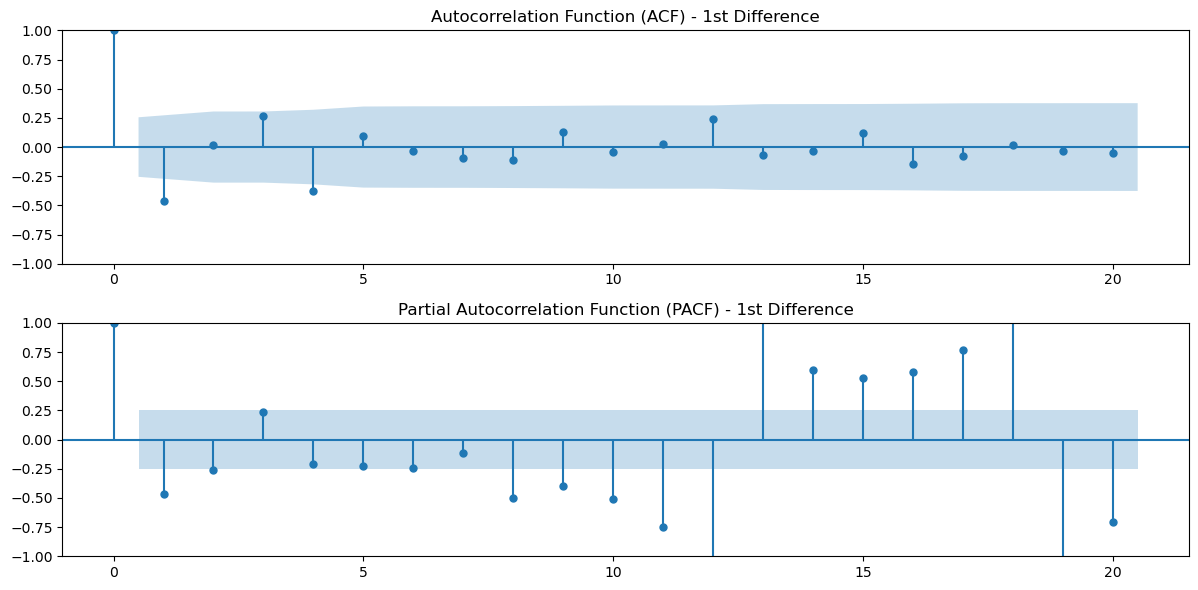

In [84]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_e_diff, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - 1st Difference')

plt.subplot(212)
plot_pacf(sales_e_diff, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - 1st Difference')

plt.tight_layout()
plt.show()

In [85]:
adf_test(sales_e_diff)

ADF Statistics: -6.125883961889508
p- value: 8.631648926998655e-08
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [86]:
train= sales_e[:57]
test=sales_e[57:]

In [87]:
print(len(train), len(test))

57 3


In [88]:
#combination p=(0,1,2,3,4,5) d=1 q=(0,1,2) must be tested with accuracy metrics and aic

In [89]:
#param = [(0,1,0),(0,1,1),(0,1,2),(1,1,0),(1,1,1),(1,1,2),(2,1,0), (2,1,1), (2, 1, 2),(3,1,0),(3,1,1),(3,1,2),(4,1,0),(4,1,1),(4,1,2),(5,1,0),(5,1,1),(5,1,2)]

#for p in param:  # Changed 'x' to 'p'
#    model = ARIMA(train, order=p).fit()
#    pred = model.forecast(steps=len(test))
#    mae = mean_absolute_error(test, pred)
#    # Calculate MAPE manually
#    mape = np.mean(np.abs((test - pred) / test)) * 100
#    mse=mean_squared_error(test, pred)
#    rmse = np.sqrt(mean_squared_error(test, pred))
#    print(p)
#    print(f'MAE: {mae}')
#    print(f'MSE: {mse}')
#    print(f'RMSE: {rmse}')
#    print('A.I.C:', model.aic)

In [90]:
order=[]
for p in range(6):
    # Loop over MA order
    for q in range(3):
        # Fit model        
#       model= ARIMA(sales_e, order=(p,1,q))
        model_t = ARIMA(train['Sales'], order=(p,1,q))
        model_test=model_t.fit() 
        pred=model_test.predict(start=len(train), end=(len(sales_e)-1))
        mae = mean_absolute_error(test, pred)
        mape = np.mean(np.abs((test - pred) / test)) * 100
        mse=mean_squared_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))
        # Add order and scores to list        
        order.append((p, q, model_test.aic, model_test.bic,mae, mse, rmse))
#Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order, columns=['p','q', 'aic', 'bic', 'mae','mse', 'rmse'])

In [91]:
# Sort by AIC
print(order_df.sort_values('aic'))

    p  q          aic          bic           mae           mse          rmse
14  4  2  1296.809353  1310.986814  10572.364215  1.173394e+08  10832.330184
17  5  2  1298.463125  1314.665939  10641.839952  1.169038e+08  10812.203992
13  4  1  1299.283043  1311.435154  21368.501070  4.629866e+08  21517.122479
16  5  1  1300.405758  1314.583220  19780.229004  3.954272e+08  19885.351605
4   1  1  1304.102201  1310.178256  29098.433396  8.832147e+08  29718.928454
11  3  2  1304.853891  1317.006001  30294.134902  9.241453e+08  30399.758572
15  5  0  1305.648884  1317.800994  23749.550675  5.707418e+08  23890.203682
1   0  1  1305.766022  1309.816725  30107.906444  9.296927e+08  30490.861877
2   0  2  1305.880173  1311.956228  29416.371351  9.010160e+08  30016.928472
7   2  1  1305.978869  1314.080275  25848.850560  6.712024e+08  25907.574428
12  4  0  1306.587351  1316.714110  24501.706146  6.070874e+08  24639.143812
8   2  2  1306.776430  1316.903188  22658.367273  5.179718e+08  22758.994213

In [92]:
m_arima= ARIMA (train, order=(4,1,2))
model_arima=m_arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   57
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -641.405
Date:                Thu, 09 May 2024   AIC                           1296.809
Time:                        21:00:10   BIC                           1310.987
Sample:                    01-01-2019   HQIC                          1302.306
                         - 09-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8875      0.226      3.928      0.000       0.445       1.330
ar.L2         -0.0200      0.237     -0.085      0.933      -0.484       0.444
ar.L3         -0.0407      0.211     -0.193      0.8

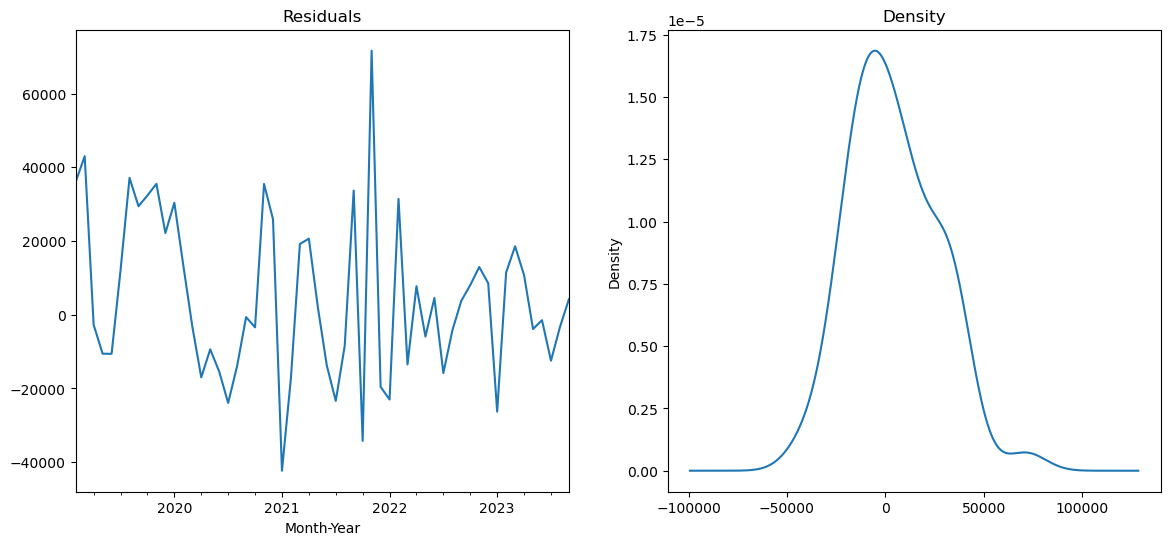

In [93]:
residuals= model_arima.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

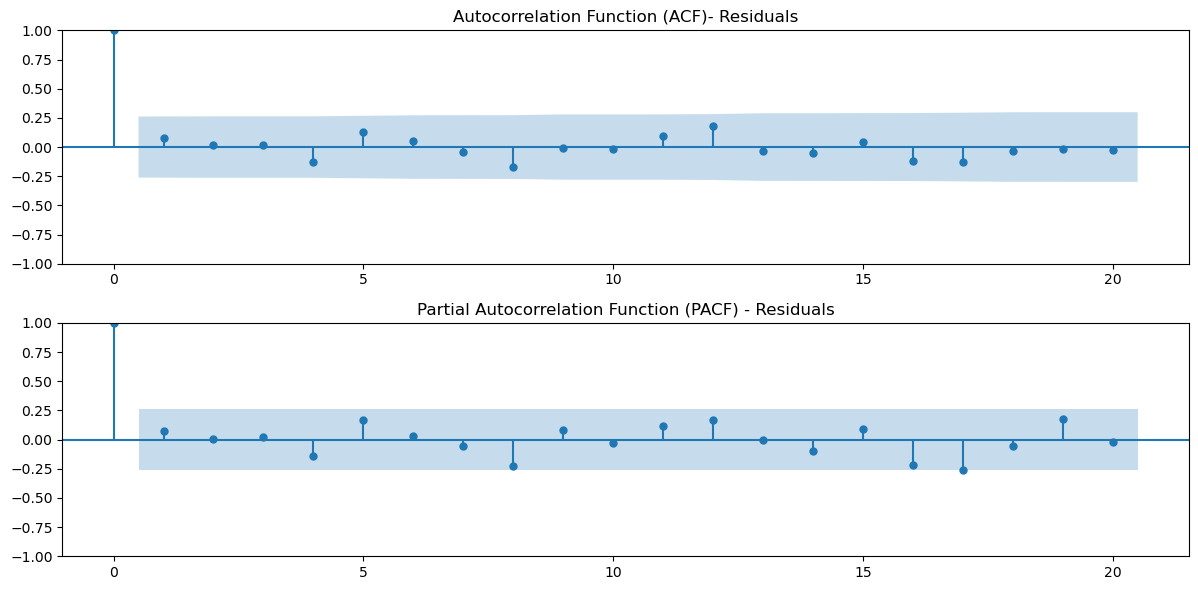

In [94]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)- Residuals')

plt.subplot(212)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Residuals')

plt.tight_layout()
plt.show()

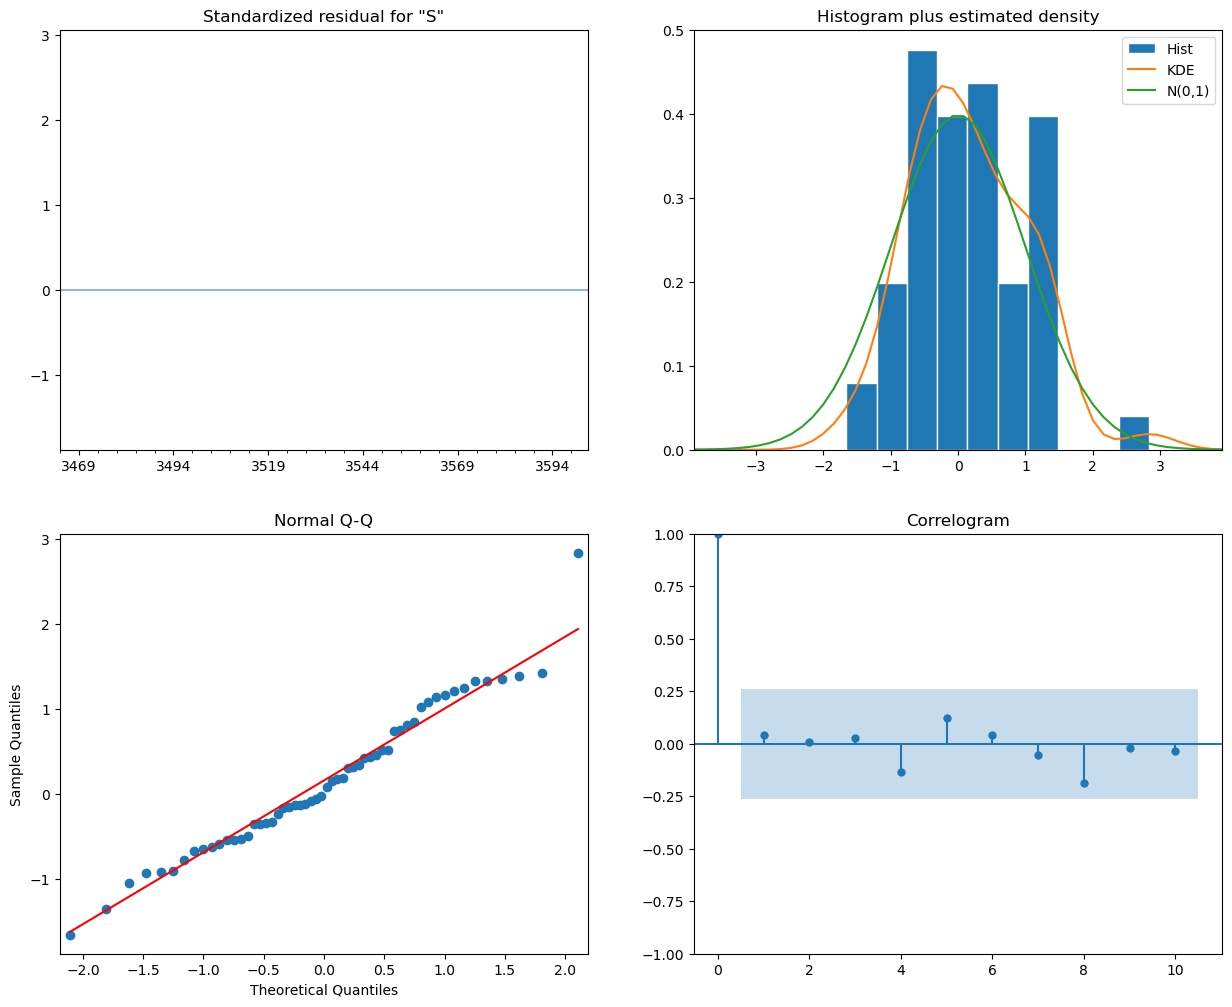

In [95]:
# Create the 4 diagostics plots
model_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [96]:
#pred=model.forecast(steps= len(test))
#sales_e['Forecast_ARIMA']=[None]*len(train) + list(pred)
#plt.figure(figsize=(14, 6))
#sales_e.plot()

In [97]:
pred=model_arima.predict(start=len(train), end=(len(sales_e)-1), dynamic = True)
sales_e['Forecast_ARIMA']=[None]*len(train) + list(pred)

Text(0.5, 1.0, 'Product E')

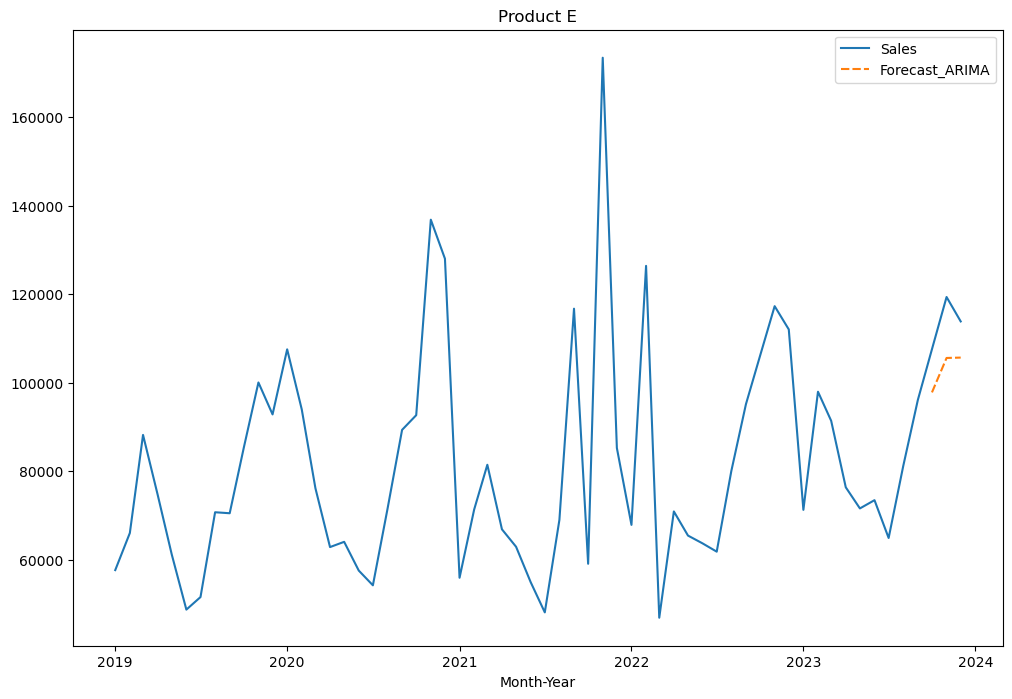

In [98]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_e)
plt.title('Product E')

In [99]:
mae_arima= mean_absolute_error(test,pred)
mse_arima=mean_squared_error(test, pred)
mape_arima= mean_absolute_percentage_error(test,pred)
rmse_arima= np.sqrt(mean_squared_error(test,pred))

print(f'MAE - ARIMA: {mae_arima}')
print(f'MAPE - ARIMA: {mape_arima}')
print(f'MSE - ARIMA: {mse_arima}')
print(f'RMSE - ARIMA: {rmse_arima}')

MAE - ARIMA: 10572.364215303014
MAPE - ARIMA: 0.09266045663927687
MSE - ARIMA: 117339377.21130826
RMSE - ARIMA: 10832.33018382048


# SARIMA

In [100]:
import statsmodels.api as sm

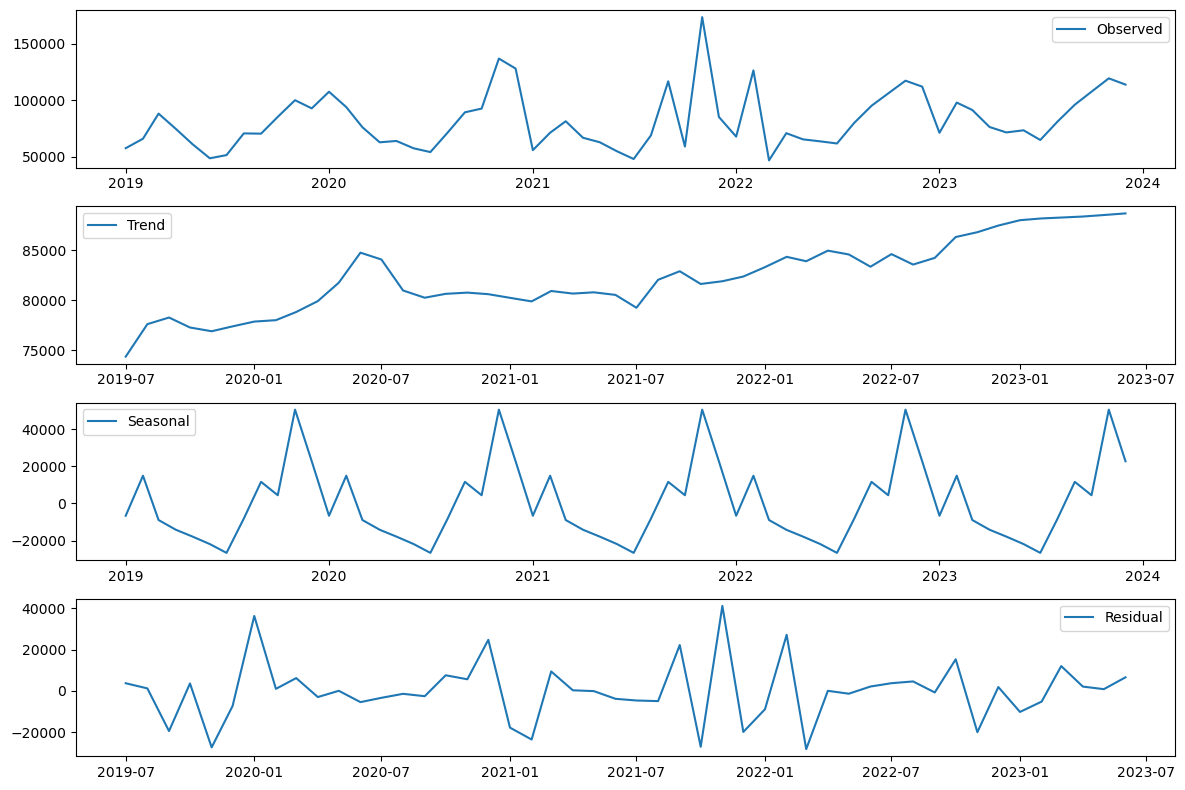

In [101]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_e['Sales'], model='additive', period=12)

# Plot the decomposition
#fig = decomposition.plot(figsize=(12,8))
#plt.show()
# Create a new figure with the specified size
plt.figure(figsize=(12, 8))

# Plot each component separately
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

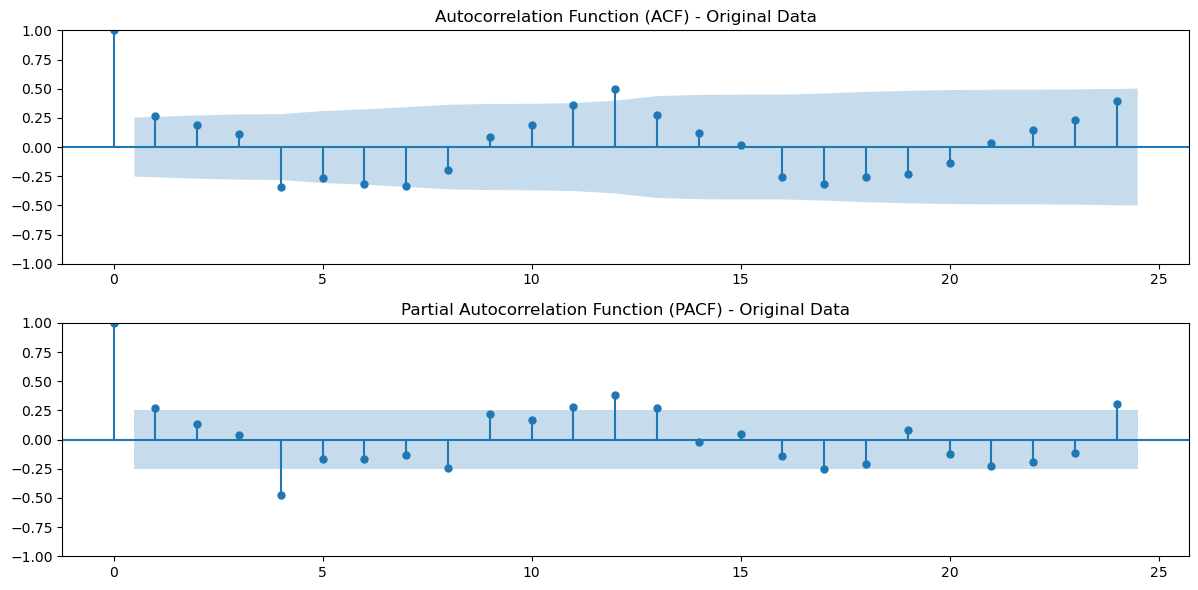

In [102]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_e['Sales'], lags=24, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Data')

plt.subplot(212)
plot_pacf(sales_e['Sales'], lags=24, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Data')

plt.tight_layout()
plt.show()

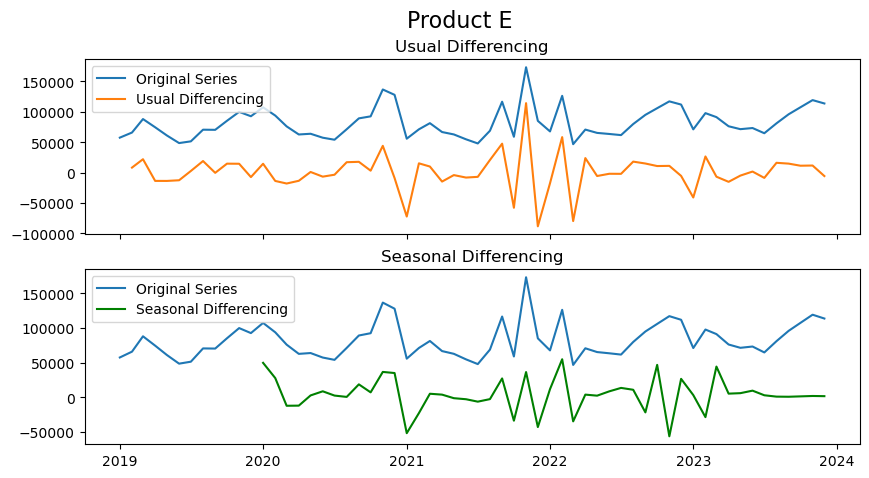

In [103]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(sales_e['Sales'], label='Original Series')
axes[0].plot(sales_e['Sales'].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(sales_e['Sales'], label='Original Series')
axes[1].plot(sales_e['Sales'].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Product E', fontsize=16)
plt.show()

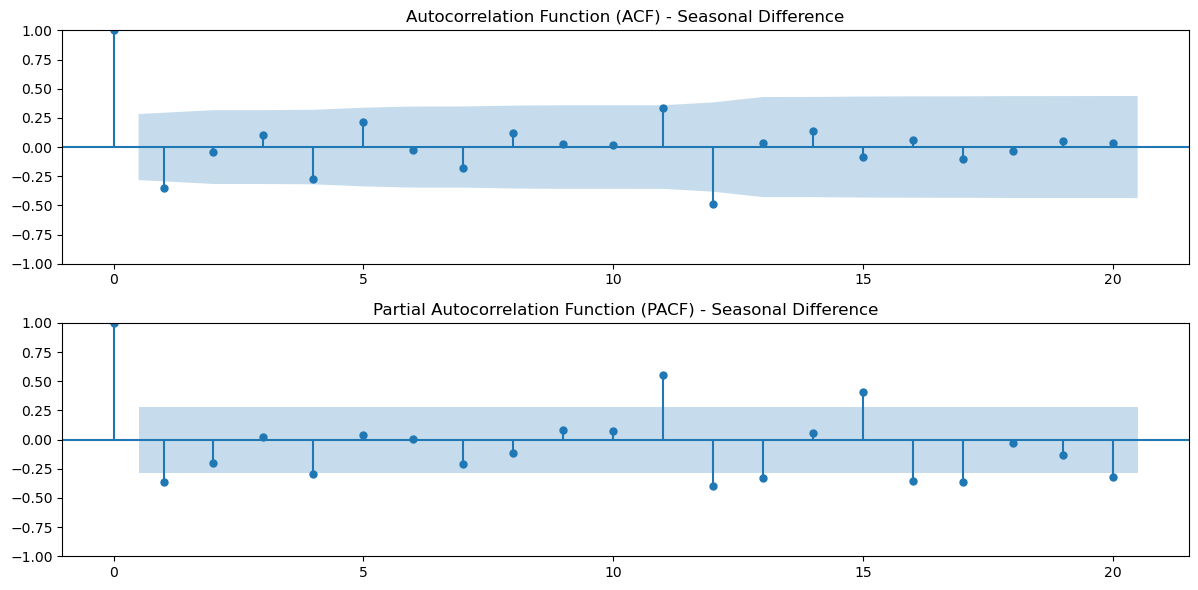

In [104]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_e['Sales'].diff(12).dropna(), lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Seasonal Difference')

plt.subplot(212)
plot_pacf(sales_e['Sales'].diff(12).dropna(), lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Seasonal Difference')

plt.tight_layout()
plt.show()

In [105]:
order_SARIMAX=[]
# Loop over P order
for P in range(5):
    # Loop over Q order
    for Q in range(3):
        # Fit model
        model_s = sm.tsa.statespace.SARIMAX(train['Sales'], order=(4, 1, 1), seasonal_order=(P, 1, Q, 12))
        model_test_s = model_s.fit() 
        pred = model_test_s.predict(start=57, end=59, dynamic=True)
        mae = mean_absolute_error(test, pred)
        mse = mean_squared_error(test, pred)
        # Add order and scores to list        
        order_SARIMAX.append((P, Q, model_test_s.aic, model_test_s.bic, mae, mse))

# Make DataFrame of model order and scores
order_SARIMAX_df = pd.DataFrame(order_SARIMAX, columns=['P', 'Q', 'aic', 'bic', 'mae', 'mse'])

In [106]:
# Sort by AIC
print(order_SARIMAX_df.sort_values('aic'))

    P  Q          aic          bic           mae           mse
1   0  1  1032.388138  1044.877466  11959.832737  1.591728e+08
2   0  2  1033.948919  1048.222436   8218.273853  7.884200e+07
4   1  1  1033.969521  1048.243038   8846.916112  8.932885e+07
6   2  0  1035.645174  1049.918691  11153.871224  1.829359e+08
7   2  1  1035.925585  1051.983292   7547.307066  6.855970e+07
5   1  2  1035.948836  1052.006543   8192.558414  7.845902e+07
9   3  0  1036.156129  1052.213835   7844.955556  9.084565e+07
12  4  0  1036.994568  1054.836465  11461.638023  1.692461e+08
3   1  0  1037.047304  1049.536632  18487.609327  3.529602e+08
10  3  1  1037.644870  1055.486766   7449.142987  6.690420e+07
8   2  2  1037.766687  1055.608584   6387.439082  5.159440e+07
13  4  1  1038.994424  1058.620510  11465.213348  1.694294e+08
11  3  2  1039.477975  1059.104061   7769.133433  8.062717e+07
14  4  2  1040.994420  1062.404696  11466.562403  1.694432e+08
0   0  0  1045.045830  1055.750968    886.195255  1.137

In [107]:
sarima=sm.tsa.statespace.SARIMAX(train['Sales'],order=(4, 1, 2),seasonal_order=(0,1,1,12))
sarima_model=sarima.fit()

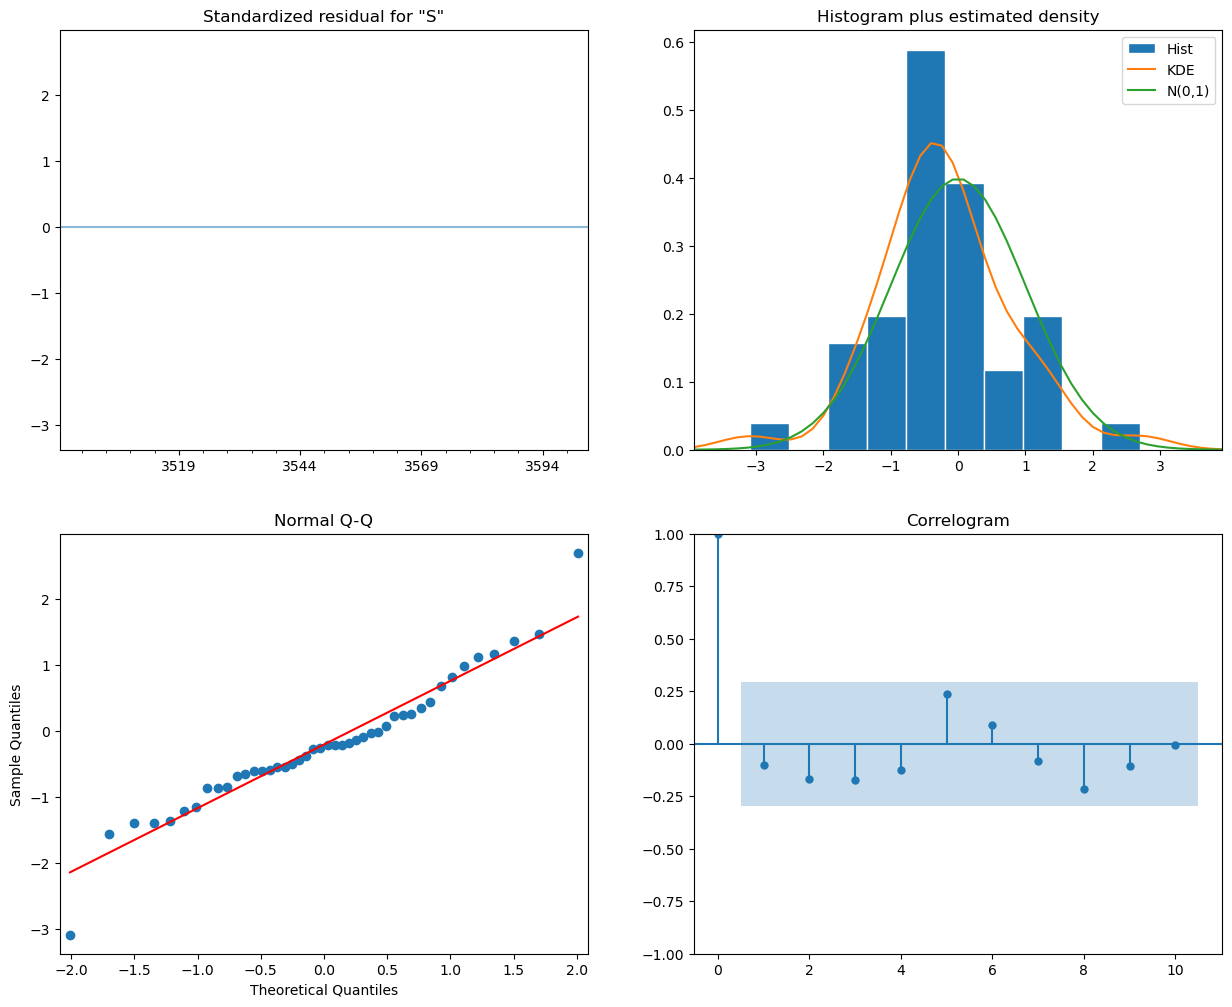

In [108]:
sarima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [109]:
forecast_test_sarima=sarima_model.predict(start=57,end=59,dynamic=True)

In [110]:
sales_e['Forecast_SARIMA']=[None]*len(train)+ list(forecast_test_sarima)
#sales_b[['Sales','Forecast_SARIMA']].plot(figsize=(12,8))

Text(0.5, 1.0, 'Product E')

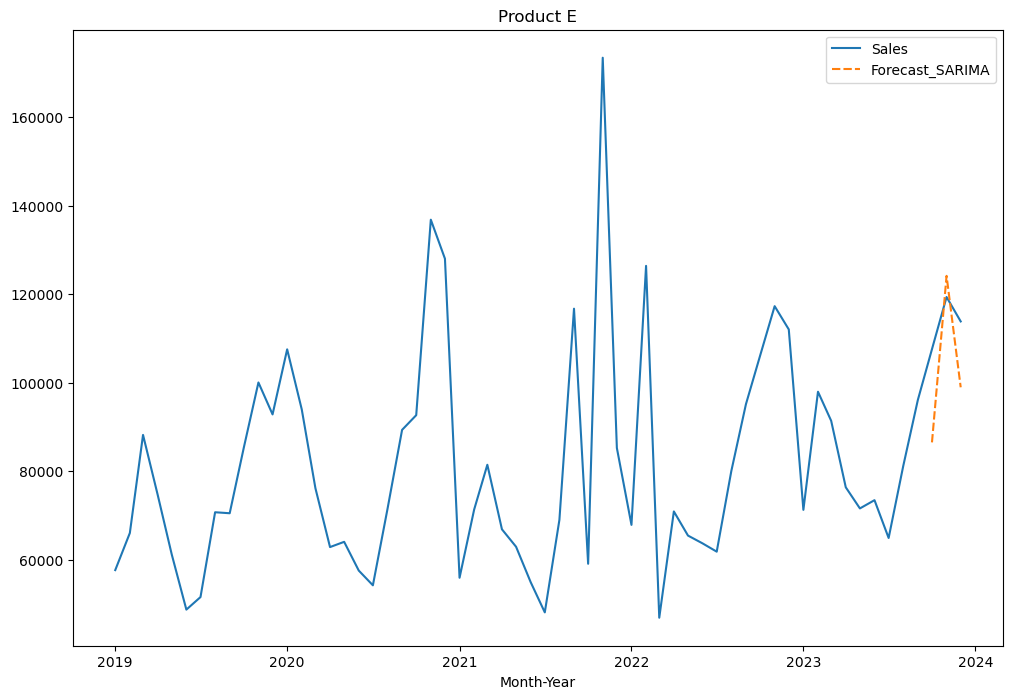

In [111]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_e[['Sales','Forecast_SARIMA']])
plt.title('Product E')

In [112]:
mae_sarima= mean_absolute_error(test,forecast_test_sarima)
mape_sarima= mean_absolute_percentage_error(test,forecast_test_sarima)
mse_sarima=mean_squared_error(test, forecast_test_sarima)
rmse_sarima= np.sqrt(mean_squared_error(test,forecast_test_sarima))

print(f'MAE - SARIMA: {round(mae_sarima,3)}')
print(f'MAPE - SARIMA: {round(mape_sarima,3)}')
print(f'MSE - SARIMA: {round(mse_sarima,3)}')
print(f'RMSE - SARIMA: {round(rmse_sarima,3)}')

MAE - SARIMA: 13575.664
MAPE - SARIMA: 0.122
MSE - SARIMA: 229351492.453
RMSE - SARIMA: 15144.355


# AUTO-ARIMA

In [41]:
import pmdarima as pm

In [42]:
auto_arima= pm.auto_arima(train, start_p=0, d=1, start_q=0, max_p=6,max_q=3,
                          start_P=0, D=1, start_Q=0, max_P=6 ,max_Q=3 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1063.748, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1051.843, Time=0.22 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=1053.545, Time=1.40 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1049.973, Time=0.08 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=1053.674, Time=0.50 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=1055.375, Time=3.59 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1059.441, Time=0.33 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.45 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=1055.672, Time=0.72 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=1057.336, Time=5.58 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=inf, Time=7.43 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=11.29 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=1057.501, Time=3.43 sec
 ARIMA(0,1,0)(4,1,0

ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [43]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   57
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -510.705
Date:                            Thu, 09 May 2024   AIC                           1031.410
Time:                                    17:16:56   BIC                           1040.331
Sample:                                01-01-2019   HQIC                          1034.718
                                     - 09-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2182      0.402     -3.033      0.002      -2.005      -0.431
ar.L2         -0.5733      0.192     -2.981      0.003      -0.950      -0.196
ma.L1          0.6005      0.460      1.305      0.192      -0.301       1.502
ma.S.L12      -0.6534      0.208     -3.147      0.002      -1.060      -0.246
sigma2      7.083e+08   4.02e-10   1.76e+18      0.000    7.08e+08    7.08e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 9.09
Prob(Q):                              0.66   Prob(JB):                         0.01
Heteroskedasticity (H):               0.18   Skew:                            -0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.86e+35. Standard errors may be unstable.
"""

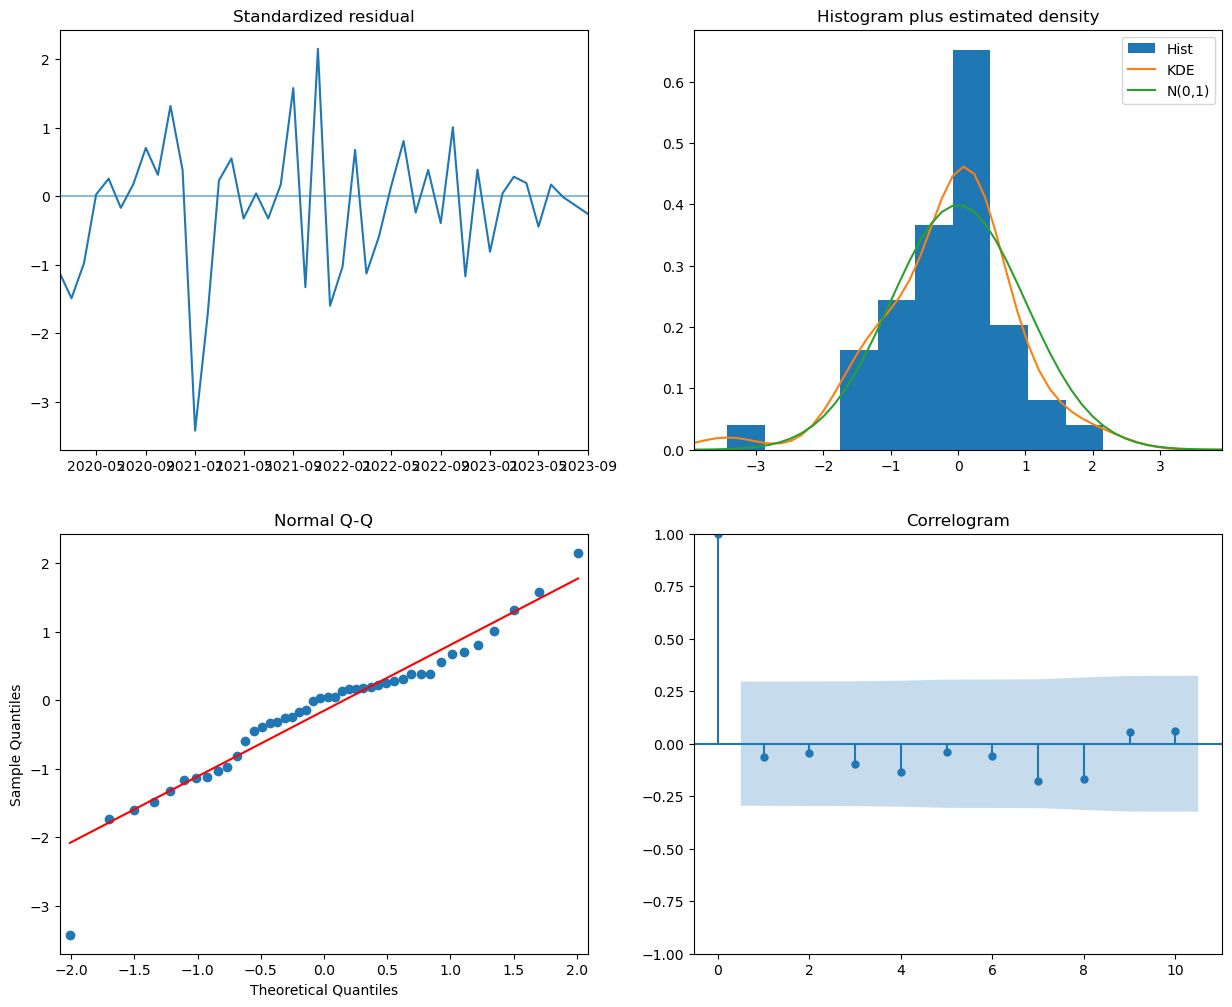

In [44]:
auto_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [45]:
forecast_test_auto= auto_arima.predict(n_periods=len(test))
sales_e['Forecast_AUTO ARIMA']=[None]*len(train)+ list(forecast_test_auto)
#sales_e[['Sales','Forecast_AUTO ARIMA']].plot()

Text(0.5, 1.0, 'Product E')

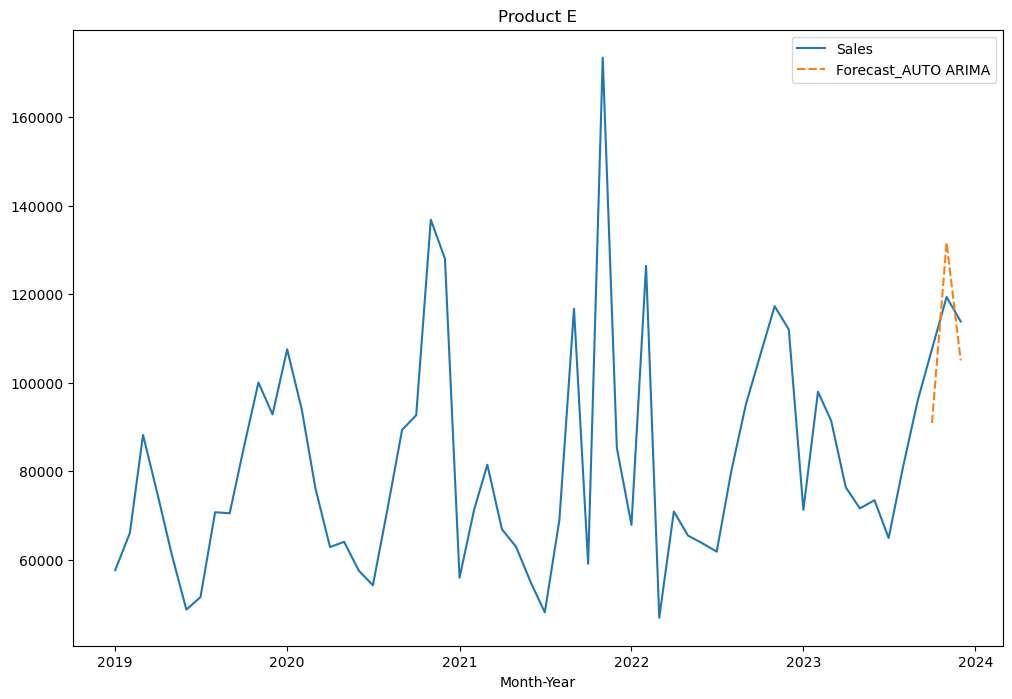

In [46]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_e[['Sales','Forecast_AUTO ARIMA']])
plt.title('Product E')

In [47]:
mae_auto_arima= mean_absolute_error(test,forecast_test_auto)
mape_auto_arima= mean_absolute_percentage_error(test,forecast_test_auto)
mse_auto_arima=mean_squared_error(test,forecast_test_auto)
rmse_auto_arima= np.sqrt(mean_squared_error(test,forecast_test_auto))

print(f'MAE - AUTO ARIMA: {mae_auto_arima}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima}')

MAE - AUTO ARIMA: 12598.522288496848
MAPE - AUTO ARIMA: 0.11183960755022315
MSE - AUTO ARIMA: 169123387.33992776
RMSE - AUTO ARIMA: 13004.744801030422


In [48]:
sales_e.tail(12)

,Sales,Forecast_ARIMA,Forecast_SARIMA,Forecast_AUTO ARIMA
Month-Year,,,,
2023-01-01,71268,NaN,NaN,NaN
2023-02-01,97965,NaN,NaN,NaN
2023-03-01,91393,NaN,NaN,NaN
2023-04-01,76364,NaN,NaN,NaN
2023-05-01,71591,NaN,NaN,NaN
2023-06-01,73457,NaN,NaN,NaN
2023-07-01,64909,NaN,NaN,NaN
2023-08-01,81175,NaN,NaN,NaN
2023-09-01,96096,NaN,NaN,NaN


In [49]:
sales_e.mean()

Sales                   82098.833333
Forecast_ARIMA          92234.832263
Forecast_SARIMA        110191.563049
Forecast_AUTO ARIMA    109201.206568
dtype: float64

In [50]:
data = {
    'model': ['ARIMA', 'AUTO ARIMA', 'SEASONAL ARIMA'],
    'MAE': [mae_arima, mae_auto_arima, mae_sarima],  
    'MAPE': [mape_arima, mape_auto_arima, mape_sarima],  
    'MSE': [mse_arima, mse_auto_arima, mse_sarima],  
    'RMSE': [rmse_arima, rmse_auto_arima, rmse_sarima]  
}

model_results = pd.DataFrame(data)
model_results.set_index('model', inplace=True)
model_results

,MAE,MAPE,MSE,RMSE
model,,,,
ARIMA,21368.501070,0.187549,4.629866e+08,21517.122479
AUTO ARIMA,12598.522288,0.111840,1.691234e+08,13004.744801
SEASONAL ARIMA,11959.832737,0.106107,1.591728e+08,12616.371763


# TESTING

In [16]:
auto_arima_1= pm.auto_arima(train, start_p=0, start_q=0, max_p=6,max_q=3,
                          start_P=0, start_Q=0, max_P=2 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima_1

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1318.257, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1312.179, Time=0.06 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=1307.947, Time=0.13 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1319.244, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1314.140, Time=0.22 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=1309.935, Time=0.19 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=1320.766, Time=0.16 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=1310.304, Time=0.86 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=1311.778, Time=0.56 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1318.215, Time=0.03 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1314.300, Time=0.08 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=1310.812, Time=0.23 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1319.508, Time=0.08 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=1316.292, Time=0.36 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=1312.811, Time=0.31

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 2, 12),
      suppress_warnings=True)

In [17]:
auto_arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:                             y   No. Observations:                   57
Model:             SARIMAX(0, 0, [1, 2], 12)   Log Likelihood                -649.973
Date:                       Wed, 08 May 2024   AIC                           1307.947
Time:                               19:16:44   BIC                           1316.119
Sample:                           01-01-2019   HQIC                          1311.123
                                - 09-01-2023                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8.044e+04   7550.956     10.653      0.000    6.56e+04    9.52e+04
ma.S.L12       0.3246      0.163      1.997      0.046       0.006       0.643
ma.S.L24       0.4092      0.382      1.072      0.284      -0.339       1.157
sigma2      6.041e+08      0.068   8.94e+09      0.000    6.04e+08    6.04e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                20.23
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                             1.21
Prob(H) (two-sided):                  0.27   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.47e+26. Standard errors may be unstable.
"""

In [18]:
forecast_test_auto_1= auto_arima_1.predict(n_periods=len(test))
sales_e['Forecast_AUTO ARIMA_1']=[None]*len(train)+ list(forecast_test_auto_1)

Text(0.5, 1.0, 'Product E')

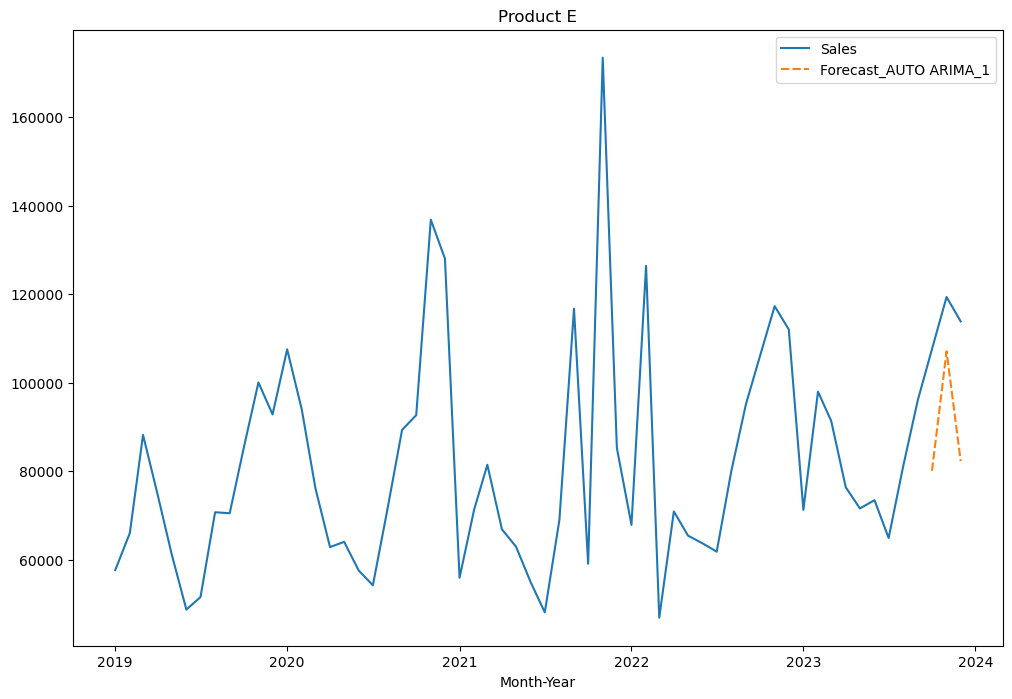

In [19]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_e[['Sales','Forecast_AUTO ARIMA_1']])
plt.title('Product E')

In [20]:
mae_auto_arima_1= mean_absolute_error(test,forecast_test_auto_1)
mape_auto_arima_1= mean_absolute_percentage_error(test,forecast_test_auto_1)
mse_auto_arima_1=mean_squared_error(test,forecast_test_auto_1)
rmse_auto_arima_1= np.sqrt(mean_squared_error(test,forecast_test_auto_1))

print(f'MAE - AUTO ARIMA: {mae_auto_arima_1}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima_1}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima_1}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima_1}')

MAE - AUTO ARIMA: 23777.082309690737
MAPE - AUTO ARIMA: 0.2118696502230122
MSE - AUTO ARIMA: 634341446.7493347
RMSE - AUTO ARIMA: 25186.13600275625
